In [1]:
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Lambda
from keras import backend as K
from keras.datasets.mnist import load_data
import numpy as np
from keras.optimizers import Adam

In [2]:
input_size = 28 * 28
temp_size = 128
latent_dim = 2

In [3]:
# defining model
inputs = keras.Input(shape=(input_size,))
x = Dense(temp_size, activation='relu')(inputs)
x = Dense(temp_size, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon
z = Lambda(sampling)([z_mean, z_log_sigma])

#encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z])

#deocder
latent_inputs = keras.Input(shape=(latent_dim,))
y= Dense(temp_size, activation='relu')(latent_inputs)
y= Dense(temp_size, activation='relu')(y)
outputs = Dense(input_size, activation='sigmoid')(y)
decoder = keras.Model(latent_inputs, outputs)

outputs = decoder(encoder(inputs)[2])
final_model = keras.Model(inputs, outputs)

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = reconstruction_loss * input_size
kl_loss = -0.5 * K.sum((1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)), axis=-1)
final_loss = K.mean(reconstruction_loss + kl_loss)
final_model.add_loss(final_loss)
opt = Adam(lr=0.0002)
final_model.compile(optimizer=opt)

In [ ]:
# loading data
(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train.astype('float32')
x_train = x_train / 255.
x_test = x_test.astype('float32')
x_test = x_test / 255.
x_train = x_train.reshape((len(x_train), 28*28))
x_test = x_test.reshape((len(x_test), 28*28))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# training
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

final_model.fit(x_train, x_train, epochs=25, batch_size=64, validation_data=(x_test, x_test), callbacks=[callback])

Epoch 1/25
938/938 [==============================] - 6s 6ms/step - loss: 222.3741 - val_loss: 177.4340
Epoch 2/25
938/938 [==============================] - 6s 6ms/step - loss: 171.9781 - val_loss: 168.1769
Epoch 3/25
938/938 [==============================] - 6s 6ms/step - loss: 166.3646 - val_loss: 164.4903
Epoch 4/25
938/938 [==============================] - 6s 6ms/step - loss: 163.3598 - val_loss: 162.1370
Epoch 5/25
938/938 [==============================] - 6s 6ms/step - loss: 161.1463 - val_loss: 160.2586
Epoch 6/25
938/938 [==============================] - 6s 6ms/step - loss: 159.1906 - val_loss: 158.4303
Epoch 7/25
938/938 [==============================] - 6s 6ms/step - loss: 157.3469 - val_loss: 156.7083
Epoch 8/25
938/938 [==============================] - 6s 6ms/step - loss: 155.6376 - val_loss: 155.1660
Epoch 9/25
938/938 [==============================] - 6s 6ms/step - loss: 154.1398 - val_loss: 153.8527
Epoch 10/25
938/938 [==============================] - 6s 6ms/st

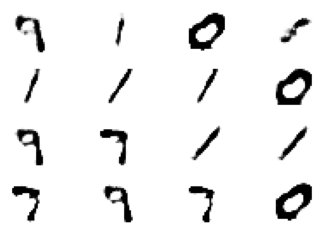

In [ ]:
# plotting generated images
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  x_decoded = decoder.predict(np.array([[np.random.uniform(-15,15),np.random.uniform(-15,15)]]))
  plt.imshow(x_decoded[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [4]:
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
_______________________________________________________________________________________

In [5]:
decoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 118,032
Trainable params: 118,032
Non-trainable params: 0
_________________________________________________________________
